## Phase 3 - Prepping data for Forecasting models

### Import Statements

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import sqlalchemy
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

In [2]:
PROC_PATH = Path("../data/processed")
VISUAL_PATH = Path("../visualizations")
DATA_PATH = Path("../data/forecasting")

df = pd.read_csv(PROC_PATH / "forecast_base.csv")

In [3]:
print("Shape:", df.shape)
print(df.dtypes)
print("\nMissing values by column:")
print(df.isna().sum())

print("\nUnique years per department:")
print(df.groupby("department")["year"].agg(["min","max","count"]))

print("\nSample data:")
display(df.head(20))

Shape: (24, 3)
department         object
year                int64
avg_total_comp    float64
dtype: object

Missing values by column:
department        0
year              0
avg_total_comp    0
dtype: int64

Unique years per department:
                       min   max  count
department                             
Admin Offices         2013  2016      4
Executive Office      2013  2016      4
IT/IS                 2013  2016      4
Production            2013  2016      4
Sales                 2013  2016      4
Software Engineering  2013  2016      4

Sample data:


,department,year,avg_total_comp
0,Admin Offices,2013,87487.075000
1,Admin Offices,2014,62197.000000
2,Admin Offices,2015,108824.094000
3,Admin Offices,2016,130617.090000
4,Executive Office,2013,41128.270000
5,Executive Office,2014,41128.270000
6,Executive Office,2015,41128.270000
7,Executive Office,2016,41128.270000
8,IT/IS,2013,112264.047500
9,IT/IS,2014,121382.506923


In [4]:
expanded_list = []

for dept, subdf in df.groupby("department"):
    subdf = subdf.sort_values("year").copy()

    # Skipping small groups
    if subdf["avg_total_comp"].notna().sum() < 2:
        print(f"Skipping interpolation for {dept} (only one data point)")
        subdf["date"] = pd.to_datetime(subdf["year"].astype(int).astype(str) + "-12-31")
        subdf["quarter"] = subdf["date"].dt.quarter
        subdf["department"] = dept
        expanded_list.append(subdf)
        continue

    # Align yearly data to end of year for better interpolation
    subdf["date"] = pd.to_datetime(subdf["year"].astype(int).astype(str) + "-12-31")
    subdf = subdf.set_index("date")

    # Generate quarterly index from first to last year
    start_date = f"{subdf.index.min().year}-03-31"   # first quarter of first year
    end_date = f"{subdf.index.max().year}-12-31"     # last quarter of last year
    full_index = pd.date_range(start=start_date, end=end_date, freq="Q")

    # Interpolate quarterly compensation
    subdf_q = (
        subdf.reindex(full_index)
             .interpolate(method="linear", limit_direction="both")
             .reset_index()
             .rename(columns={"index": "date"})
    )

    # Add time features
    subdf_q["year"] = subdf_q["date"].dt.year
    subdf_q["quarter"] = subdf_q["date"].dt.quarter
    subdf_q["department"] = dept

    expanded_list.append(subdf_q)

# Combine all departments
df_quarterly = pd.concat(expanded_list, ignore_index=True)
df_quarterly = df_quarterly.sort_values(["department", "date"]).reset_index(drop=True)

print("Quarterly interpolation complete.")
print(df_quarterly.groupby("department")["avg_total_comp"].agg(["min", "max", "count"]))
display(df_quarterly.head(10))

Quarterly interpolation complete.
                                min            max  count
department                                               
Admin Offices          62197.000000  130617.090000     16
Executive Office       41128.270000   41128.270000     16
IT/IS                 103125.505789  121382.506923     16
Production             78126.324082  102118.938286     16
Sales                  72951.922222  121329.460000     16
Software Engineering   52243.860000  120011.258333     16


,date,department,year,avg_total_comp,quarter
0,2013-03-31,Admin Offices,2013,87487.07500,1
1,2013-06-30,Admin Offices,2013,87487.07500,2
2,2013-09-30,Admin Offices,2013,87487.07500,3
3,2013-12-31,Admin Offices,2013,87487.07500,4
4,2014-03-31,Admin Offices,2014,81164.55625,1
5,2014-06-30,Admin Offices,2014,74842.03750,2
6,2014-09-30,Admin Offices,2014,68519.51875,3
7,2014-12-31,Admin Offices,2014,62197.00000,4
8,2015-03-31,Admin Offices,2015,73853.77350,1
9,2015-06-30,Admin Offices,2015,85510.54700,2


In [5]:
# Sample Visualizations

# Get all unique departments
departments = df_quarterly["department"].unique()

# Loop through each department
for dept in departments:
    plt.figure(figsize=(10, 5))
    
    # Quarterly (interpolated)
    sns.lineplot(
        data=df_quarterly[df_quarterly["department"] == dept],
        x="date",
        y="avg_total_comp",
        marker="o",
        label="Quarterly (Interpolated)",
        color="steelblue"
    )

    # Yearly (original)
    orig = df[df["department"] == dept]
    plt.scatter(
        pd.to_datetime(orig["year"].astype(str) + "-12-31"),
        orig["avg_total_comp"],
        color="red",
        s=60,
        label="Original Yearly"
    )

    # Titles & formatting
    plt.title(f"Quarterly Interpolation — {dept}")
    plt.xlabel("Date")
    plt.ylabel("Average Total Compensation ($)")
    plt.legend()
    plt.tight_layout()

    # Save figure
    safe_name = (
    dept.replace(" ", "_")
        .replace("/", "_")
        .replace("&", "and")
        .replace("-", "_")
        .lower()
    )

    plot_path = VISUAL_PATH / f"quarterly_interpolation_{safe_name}.png"
    plt.savefig(plot_path, dpi=120)
    plt.close() # close to save memory in loop
    print(f"Save image for ", dept)

Save image for  Admin Offices
Save image for  Executive Office
Save image for  IT/IS
Save image for  Production       
Save image for  Sales
Save image for  Software Engineering


In [6]:
# Saving the data for model
df_quarterly.to_csv(DATA_PATH/"forecast_input.csv", index=False)
df_quarterly.to_parquet(DATA_PATH/"forecast_input.parquet", index=False)

print("Saved the data for models.")

Saved the data for models.


In [7]:
# VALIDATION — Quarterly Expansion Sanity Check

# Count records per department in yearly vs quarterly
yearly_counts = df.groupby("department")["year"].nunique().reset_index(name="year_count")
quarterly_counts = df_quarterly.groupby("department")["date"].nunique().reset_index(name="quarter_count")

# Merge for comparison
coverage_check = pd.merge(yearly_counts, quarterly_counts, on="department", how="left")

# Compute expected vs actual ratio
coverage_check["expected_quarters"] = coverage_check["year_count"] * 4
coverage_check["ratio_actual_to_expected"] = (coverage_check["quarter_count"] / coverage_check["expected_quarters"]).round(2)

print("Quarterly Expansion Validation Summary:")
display(coverage_check)

# Check for any missing or duplicated quarterly periods
missing_check = (
    df_quarterly.groupby("department")["quarter"]
    .count()
    .reset_index(name="total_quarters")
)
print("\nQuarterly Record Count per Department:")
display(missing_check)

# Ensure there are no duplicate date–department combinations
dup_count = df_quarterly.duplicated(subset=["department", "date"]).sum()
print(f"\nDuplicate Department–Date combinations: {dup_count}")

Quarterly Expansion Validation Summary:


,department,year_count,quarter_count,expected_quarters,ratio_actual_to_expected
0,Admin Offices,4,16,16,1.0
1,Executive Office,4,16,16,1.0
2,IT/IS,4,16,16,1.0
3,Production,4,16,16,1.0
4,Sales,4,16,16,1.0
5,Software Engineering,4,16,16,1.0



Quarterly Record Count per Department:


,department,total_quarters
0,Admin Offices,16
1,Executive Office,16
2,IT/IS,16
3,Production,16
4,Sales,16
5,Software Engineering,16



Duplicate Department–Date combinations: 0


### Interpretation:

This confirms that the interpolation worked well and Prophet will now have enough data granularity which is 4× denser than yearly stats.

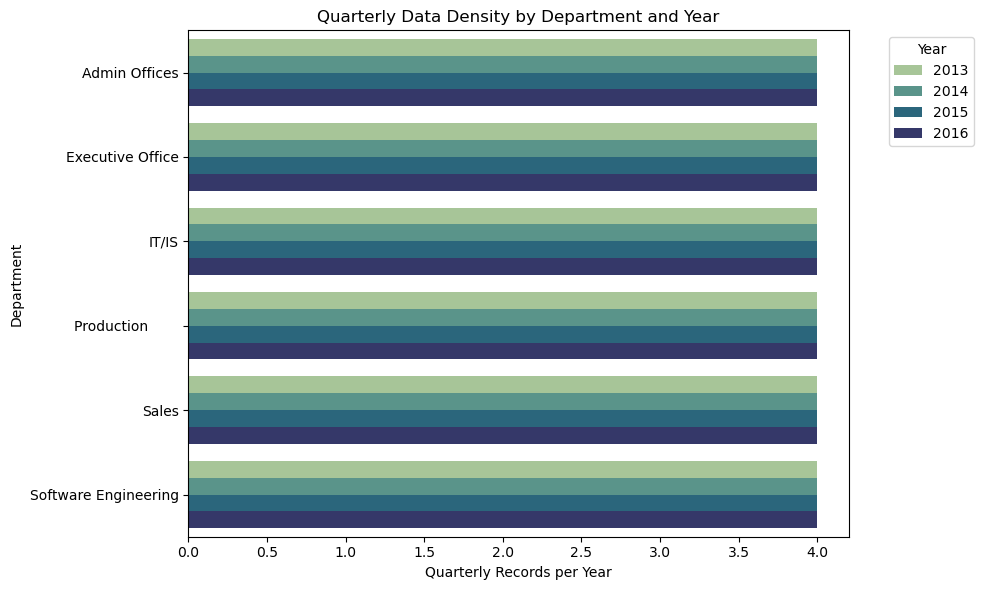

In [8]:
# Visually confirm the density

plt.figure(figsize=(10,6))
sns.countplot(
    data=df_quarterly,
    y="department",
    hue="year",
    palette="crest"
)
plt.title("Quarterly Data Density by Department and Year")
plt.xlabel("Quarterly Records per Year")
plt.ylabel("Department")
plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(VISUAL_PATH/'quaterly_data_density_by_dept_and_year.png', dpi=100)
plt.show()